# Using RRBM: Examples of CRBM networks

1. using the compiled libraries (GSL)
2. using the native R libraries

#### Load Libraries

In [1]:
library(rrbm);

## CRBMs: the Motion example

### Load Dataset

A fragment of the Motion Dataset (by Eugene Hu) is included in the package for testing purposes. It can be loaded as "motionfrag", and it is normalized

In [2]:
data(motionfrag)

### Train the CRBM

The CRBM receives as inputs:
* batchdata: the datasets to be trained with. This dataset contains time series, each in order (from older to newer inputs). Batchdata can contain several series, concatenated.
* seqlen: the lenght of each concatenated sequence in batchdata. The sum of seqlen has to match the length of batchdata

Also receives the following hyperparameters:
* batch_size: the size of each training mini-batch
* n_hidden: the number of hidden units
* delay: the size of the history for each input. When training, the first _d_ inputs will be used for history of element _d+1_
* training_epochs: the number of training epochs
* learning_rate: the learning rate for Gradient Descent
* momentum: the momentum for Gradient Descent
* rand_seed: the random seed. CRBMs are stochastic, and each run can provide different results

In [3]:
crbm_mfrag <- train.crbm(motionfrag$batchdata,
                         motionfrag$seqlen,
                         batch_size = 100,
                         n_hidden = 100,
                         delay = 6,
                         training_epochs = 10,
                         learning_rate = 1e-3,
                         momentum = 0.5,
                         rand_seed = 1234
);

### Predict (pass through) using the CRBM

There are 3 methods: predict.crbm, forward.crbm and backward.crbm

* predict.crbm: passes the dataset forward and backward through the CRBM.
  * It assumes that the input is a time series. It takes the first _d_ elements (_d_ as in _delay_) as the history of _d+1_, then slides the window towards the last input.
  * The first _d_ inputs receive an array of zeros as activation and reconstruction
  * The time series goes from _1_ (oldest input) to _n_ (newest input)
  * The input is considered a SINGLE time series

In [4]:
first_sequence <- motionfrag$batchdata[1:motionfrag$seqlen[1],];

crbm_pred1 <- predict(crbm_mfrag, first_sequence);
str(crbm_pred1);

List of 2
 $ reconstruction: num [1:438, 1:49] 0 0 0 0 0 ...
 $ activation    : num [1:438, 1:100] 0 0 0 0 0 ...


* forward.crbm: passes the dataset forward only, returning activations only.
  * It also considers the input as a time series, and builds the history as _predict.crbm_
  * The first _d_ inputs receive an array of zeros as activation
  * The time series goes from _1_ (oldest input) to _n_ (newest input)

In [5]:
first_sequence <- motionfrag$batchdata[1:motionfrag$seqlen[1],];

act_1 <- forward.crbm(crbm_mfrag, first_sequence);
str(act_1);

 num [1:438, 1:100] 0 0 0 0 0 ...


* backward.crbm: passes a set of activations back the CRBM, returning the reconstructions.
  * It requires to receive the _history_ for each element.
  * It considers the input as the activations of a time series, so for an input of _n_ activations, requires a history dataset of _d+n-1_ inputs
  * The element _1_ of activation relates to _history 1:d_, then slides the window towards the last input.

In [6]:
activations <- act_1[(crbm_mfrag$delay+1):nrow(act_1),];
corresp_hist <- motionfrag$batchdata[1:motionfrag$seqlen[1]-1,];

rec_1 <- backward.crbm(crbm_mfrag, activations, corresp_hist);
str(rec_1);

 num [1:432, 1:49] -0.214 -0.247 -0.244 -0.245 -0.192 ...


### Forecast using the CRBM

Function forecast.crbm **predicts** future inputs for a time series. It uses the last element of the input series, plus the _n-1:n-d_ elements as _history_, to forecast the inputs for the expected *n\_samples*

In [7]:
first_sequence <- motionfrag$batchdata[1:motionfrag$seqlen[1],];

crbm_pred2 <- forecast.crbm(crbm_mfrag, first_sequence, n_samples = 50);
str(crbm_pred2);

List of 1
 $ generated: num [1:50, 1:49] -0.24 -0.213 -0.283 -0.153 -0.125 ...


### Update / Re-train a CRBM

You can pass a trained CRBM as initial values for a new CRBM. The properties of the CRBM must match with the CRBM passed as **init_crbm**. The function returns a new updated copy of the old CRBM

In [8]:
crbm_mf2 <- train.crbm(motionfrag$batchdata,
                       motionfrag$seqlen,
                       batch_size = 100,
                       n_hidden = 100,
                       delay = 6,
                       training_epochs = 10,
                       learning_rate = 1e-3,
                       momentum = 0.5,
                       rand_seed = 1234,
                       init_crbm = crbm_mfrag
);

## Using the R native functions

In [9]:
rm (list = ls());

### Load the R sources

In [10]:
setwd("..");
source("./R tools/crbm.R");
source("./R tools/crbm_series.R");
setwd("notebooks");

### Load Dataset

To load the "motionfrag" data without using the compiled package, you can load and prepare it from the RDS file, using the following function.

The function will return a list with the **batchdata**, the **seqlen**, and the **data_mean** and **data_std** of the data once normalized

In [11]:
load_data <- function(filename)
{
    mat_dict <- readRDS(filename);
    Motion <- mat_dict[['Motion']];

    n_seq <- length(Motion);

    # assume data is MIT format for now
    indx <- c(1:9, 14, 19:21, 26, 31:33, 38, 43:45, 50, 55:57, 61:63, 67:69, 73:75,
                79:81, 85:87, 91:93, 97:99, 103:105);

    ##row1 <- Motion[[c(1,1)]][1,];
    ##offsets <- array(row1[c(10:12, 16:18, 22:24, 28:30, 34:36, 40:42, 46:48, 52:54,
    ##            58:60, 64:66, 70:72, 76:78, 82:84, 88:90, 94:96, 100:102,
    ##            106:108)], c(3, length(row1)/3) );

    # collapse sequences
    batchdata <- rbind(Motion[[c(1,1)]][,indx],
                       Motion[[c(2,1)]][,indx],
                       Motion[[c(3,1)]][,indx]);
    data_mean <- colMeans(batchdata);
    data_std <- apply(batchdata, 2, sd);

    batchdata <- t((t(batchdata) - data_mean) / data_std);

    # get sequence lengths
    seqlen <- sapply(1:3, function(x) nrow(Motion[[c(x,1)]]));

    list(batchdata = batchdata, seqlen = seqlen, data_mean = data_mean, data_std = data_std);
}

In [12]:
dataset <- load_data('../R tools/datasets/motion.rds');
str(dataset)

List of 4
 $ batchdata: num [1:3826, 1:49] -0.258 -0.23 -0.134 -0.234 -0.163 ...
 $ seqlen   : int [1:3] 438 260 3128
 $ data_mean: num [1:49] 1.58179 1.5854 0.00448 36.99363 -1.43077 ...
 $ data_std : num [1:49] 0.0537 0.0896 0.0403 14.3277 10.0685 ...


### Train the CRBM

In contrast to the packaged version, **dataset** must be a list containing **batchdata** and **seqlen**

In [13]:
crbm <- train_crbm (dataset,
                    batch_size = 100,
                    n_hidden = 100,
                    delay = 6,
                    training_epochs = 200,
                    learning_rate = 1e-3,
                    momentum = 0.5,
                    rand_seed = 1234
);

[1] "Training epoch 1, cost is 26.9140663163529"
[1] "Training epoch 51, cost is 5.66116568699741"
[1] "Training epoch 101, cost is 5.09535731985935"
[1] "Training epoch 151, cost is 4.86474796826722"
[1] "Training took 45.0041279792786"


### Predict (pass through) using the CRBM

There are 3 methods: predict_crbm, forward_crbm and backward_crbm
* predict_crbm: passes the dataset forward and backward through the CRBM (in the native version, predict is not an S3 function)
  * It assumes that the input is a time series. It takes the first d elements (d as in delay) as the history of d+1, then slides the window towards the last input.
  * The first d inputs receive an array of zeros as activation and reconstruction
  * The time series goes from 1 (oldest input) to n (newest input)
  * The input is considered a SINGLE time series

In [14]:
first_sequence <- dataset$batchdata[1:dataset$seqlen[1],];

crbm_pred1 <- predict_crbm(crbm, first_sequence);
str(crbm_pred1);

List of 2
 $ activations   : num [1:432, 1:100] 0.514 0.509 0.488 0.478 0.503 ...
 $ reconstruction: num [1:432, 1:49] -0.1126 -0.2344 -0.2172 -0.1488 -0.0313 ...


The native version also accepts the history to be passed as a parameter, then the batchdata will not be treated as time series, but as a set of inputs with its respective history to be treated.

The _history_ parameter bust contain _d_ inputs, ordered from newest to older: for each input _i_ in batchdata, history contains _i_ for _t-1:t-d_ in one single row

In [15]:
batchdata <- dataset$batchdata;

# pick some starting points for each sequence
data_idx <- c(100, 200, 400, 600);
orig_data <- batchdata[data_idx,];

hist_idx <- c(sapply(data_idx, function(x) x - 1:crbm$delay));
orig_history <- t(array(as.vector(t(batchdata[hist_idx,])), c(crbm$delay * crbm$n_visible, length(data_idx))));

aux <- predict_crbm(crbm, orig_data, history = orig_history);
str(aux);

List of 2
 $ activations   : num [1:4, 1:100] 0.506 0.578 0.435 0.525 0.51 ...
 $ reconstruction: num [1:4, 1:49] 1.861 -1.847 0.994 0.368 -0.254 ...


* forward.rbm: passes the dataset forward only, returning activations only.
  * It also considers the input as a time series, and builds the history as predict_crbm
  * The first d inputs receive an array of zeros as activation
  * The time series goes from 1 (oldest input) to n (newest input)

In [16]:
first_sequence <- dataset$batchdata[1:dataset$seqlen[1],];

act_1 <- forward_crbm(crbm, first_sequence);
str(act_1);

 num [1:432, 1:100] 0.514 0.509 0.488 0.478 0.503 ...


In [17]:
batchdata <- dataset$batchdata;

# pick some starting points for each sequence
data_idx <- c(100, 200, 400, 600);
orig_data <- batchdata[data_idx,];

hist_idx <- c(sapply(data_idx, function(x) x - 1:crbm$delay));
orig_history <- t(array(as.vector(t(batchdata[hist_idx,])), c(crbm$delay * crbm$n_visible, length(data_idx))));

aux <- forward_crbm(crbm, orig_data, history = orig_history);
str(aux);

 num [1:4, 1:100] 0.506 0.578 0.435 0.525 0.51 ...


* backward.crbm: passes a set of activations back the CRBM, returning the reconstructions.
  * It requires to receive the _history_ for each element.
  * It considers the input as the activations of a time series, so for an input of _n_ activations, requires a history dataset of _d+n-1_ inputs
  * The element _1_ of activation relates to _history 1:d_, then slides the window towards the last input.

In [18]:
activations <- act_1[(crbm$delay+1):nrow(act_1),];
corresp_hist <- dataset$batchdata[1:dataset$seqlen[1]-1,];

rec_1 <- backward_crbm(crbm, activations, corresp_hist);
str(rec_1);

 num [1:426, 1:49] -0.1019 -0.2255 -0.2143 -0.1515 -0.0342 ...


### Forecasting using the CRBM

In the native R version, the forecasting function allows to introduce data as a single time series (picking the newest element _n_ and generating history _n-1:n-d_ automatically), or introduce manually history, so original data is not treated as a same time series.

In [19]:
idx <- dataset$seqlen[1];
first_sequence <- dataset$batchdata[1:idx,, drop=FALSE];

crbm_pred2 <- forecast_crbm(crbm, orig_data = first_sequence, orig_history = NULL, n_samples = 50, n_gibbs = 30);
str(crbm_pred2);

 num [1, 1:50, 1:49] 1.77 1.79 1.53 1.23 1.16 ...


And now here with independent series. Notice that the history must be "hand crafted", and admits several head series

In [20]:
batchdata <- dataset$batchdata;

# pick some starting points for each sequence
data_idx <- c(100, 200, 400, 600);
orig_data <- batchdata[data_idx,];

hist_idx <- c(sapply(data_idx, function(x) x - 1:crbm$delay));
orig_history <- t(array(as.vector(t(batchdata[hist_idx,])), c(crbm$delay * crbm$n_visible, length(data_idx))));
                     
generated_series.aux <- forecast_crbm(crbm, orig_data, orig_history, n_samples = 100, n_gibbs = 30);

# append initialization
library(abind)
oh.temp <- aperm(array(as.vector(orig_history), c(length(data_idx), crbm$n_visible, crbm$delay)),c(1,3,2));
generated_series <- abind(oh.temp[,crbm$delay:1,], generated_series.aux, along = 2);
dimnames(generated_series) <- NULL;

str(generated_series)

 num [1:4, 1:106, 1:49] 1.846 -1.23 1.188 -0.295 2.144 ...


#### Plot first dimension of each sequence

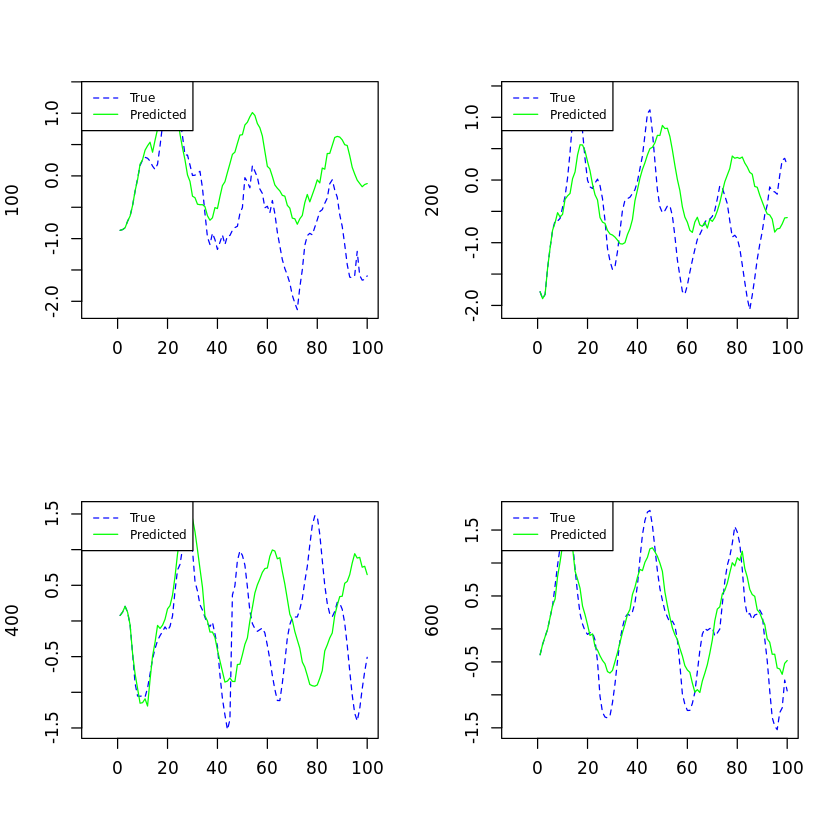

In [21]:
par(mfrow = c(ceiling(length(data_idx)/2),2));
for (i in 1:length(data_idx))
{
    start <- data_idx[i];

    plot.true <- batchdata[(start - crbm$delay):(start + 100 - crbm$delay - 1), 2];
    plot.pred <- generated_series[i, 1:100, 2];

    plot(plot.true, col = "blue", type = "l", lty = 2, xlab = "", ylab = data_idx[i],
         xlim = c(-10,100), ylim = c(min(plot.true, plot.pred),max(plot.true, plot.pred)));
    lines(plot.pred, col = "green");
    legend("topleft", legend = c("True", "Predicted"), col = c("blue","green"),
           lty = c(2,1), cex = 0.75, y.intersp = 1);
}